In [1]:
options(warn = -1, tidyverse.quiet = T)

library(tidyverse, warn.conflicts = F, quietly = T)
library(arrow, warn.conflicts = F)
library(cowplot, warn.conflicts = F)
library(yardstick, warn.conflicts = F)
library(scattermore)
library(colorspace)

In [2]:
feature_phenotypes <- c(
    "Cerebral infarction" = "b_I63",
    "Acute myocardial infarction" = "b_I21",
    "Essential hypertension" = "b_I10",
    "Obesity" = "b_E66",
    "Acute ischemic heart disease" = "b_I24",
    "Ischemic heart disease" = "b_I25",
    "Pulmonary heart diseases" = "b_I27",
    "Other heart disease" = "b_I51",
    "Other cerebrovascular" = "b_I67",
    "Type 1 diabetes mellitus" = "b_E10",
    "Type 2 diabetes mellitus" = "b_E11",
    "HbA1c" = "q_30750_0",
    "HDL cholesterol" = "q_30760_0",
    "Glucose" = "q_30740_0",
    "Cholesterol" = "q_30690_0",
    "Triglycerides" = "q_30870_0",
    "Lipoprotein A" = "q_30790_0",
    "Apolipoprotein B" = "q_30640_0",
    "Creatinine" = "q_30700_0"
)
reversed_feature_phenotypes = names(feature_phenotypes) %>% set_names(feature_phenotypes)

megastroke_phenotypes <- c(
    AS = "Any",
    AIS = "Ischemic",
    LAS = "Large artery",
    CES = "Cardioembolic",
    SVS = "Small vessel"
)
reversed_megastroke_phenotypes = names(megastroke_phenotypes) %>% set_names(megastroke_phenotypes)

In [3]:
naive_df <- read_tsv("data/pheno/naive.tsv", show_col_types = F, 
                     col_types = cols(.default = col_double()))

maxgcp_df <- read_tsv("data/pheno/maxgcp.tsv", show_col_types = F, 
                      col_types = cols(.default = col_double()))

merged_df <- naive_df %>%
    inner_join(maxgcp_df, by = c("FID", "IID")) %>%
    select(-contains("sub"))

merged_df %>% head(0)

FID,IID,b_E10,b_E11,b_E66,b_I10,b_I21,b_I24,b_I25,b_I27,⋯,q_30700_0,q_30740_0,q_30750_0,q_30760_0,q_30790_0,q_30870_0,maxgcp_full_1.AS,maxgcp_full_2.AIS,maxgcp_full_4.CES,maxgcp_full_5.SVS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


# Reverse approach

In [4]:
lm_df <- merged_df %>%
    mutate(across(starts_with(c("b_", "q_")), ~scale(.) %>% as.double)) %>%
    pivot_longer(starts_with("maxgcp"), names_to = "maxgcp_type", values_to = "maxgcp") %>%
    select(maxgcp_type, maxgcp, starts_with("b_"), starts_with("q_")) %>%
    nest(data = -maxgcp_type) %>%
    rowwise() %>%
    mutate(
        reg = lm(maxgcp ~ . + 0, data = data) %>%
            broom::tidy() %>%
            list
    ) %>%
    select(-data) %>%
    unnest(reg)

lm_df %>% head(2)

maxgcp_type,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
maxgcp_full_1.AS,b_E10,1.697613,0.5608832,3.026678,0.002472758
maxgcp_full_1.AS,b_E11,2.114616,0.6376055,3.316496,0.000911635


In [5]:
plot_df <- lm_df %>%
    filter(term != "(Intercept)") %>%
    arrange(maxgcp_type, desc(estimate)) %>%
    mutate(
        phenotype = maxgcp_type %>% 
            str_remove("maxgcp_full_[0-5]\\.") %>%
            recode(!!!megastroke_phenotypes),
        term = term %>% recode(!!!reversed_feature_phenotypes)
    ) %>%
    select(term, phenotype, estimate)

plot_df %>% head(2)

term,phenotype,estimate
<chr>,<chr>,<dbl>
Pulmonary heart diseases,Any,3.140348
Acute ischemic heart disease,Any,3.034054


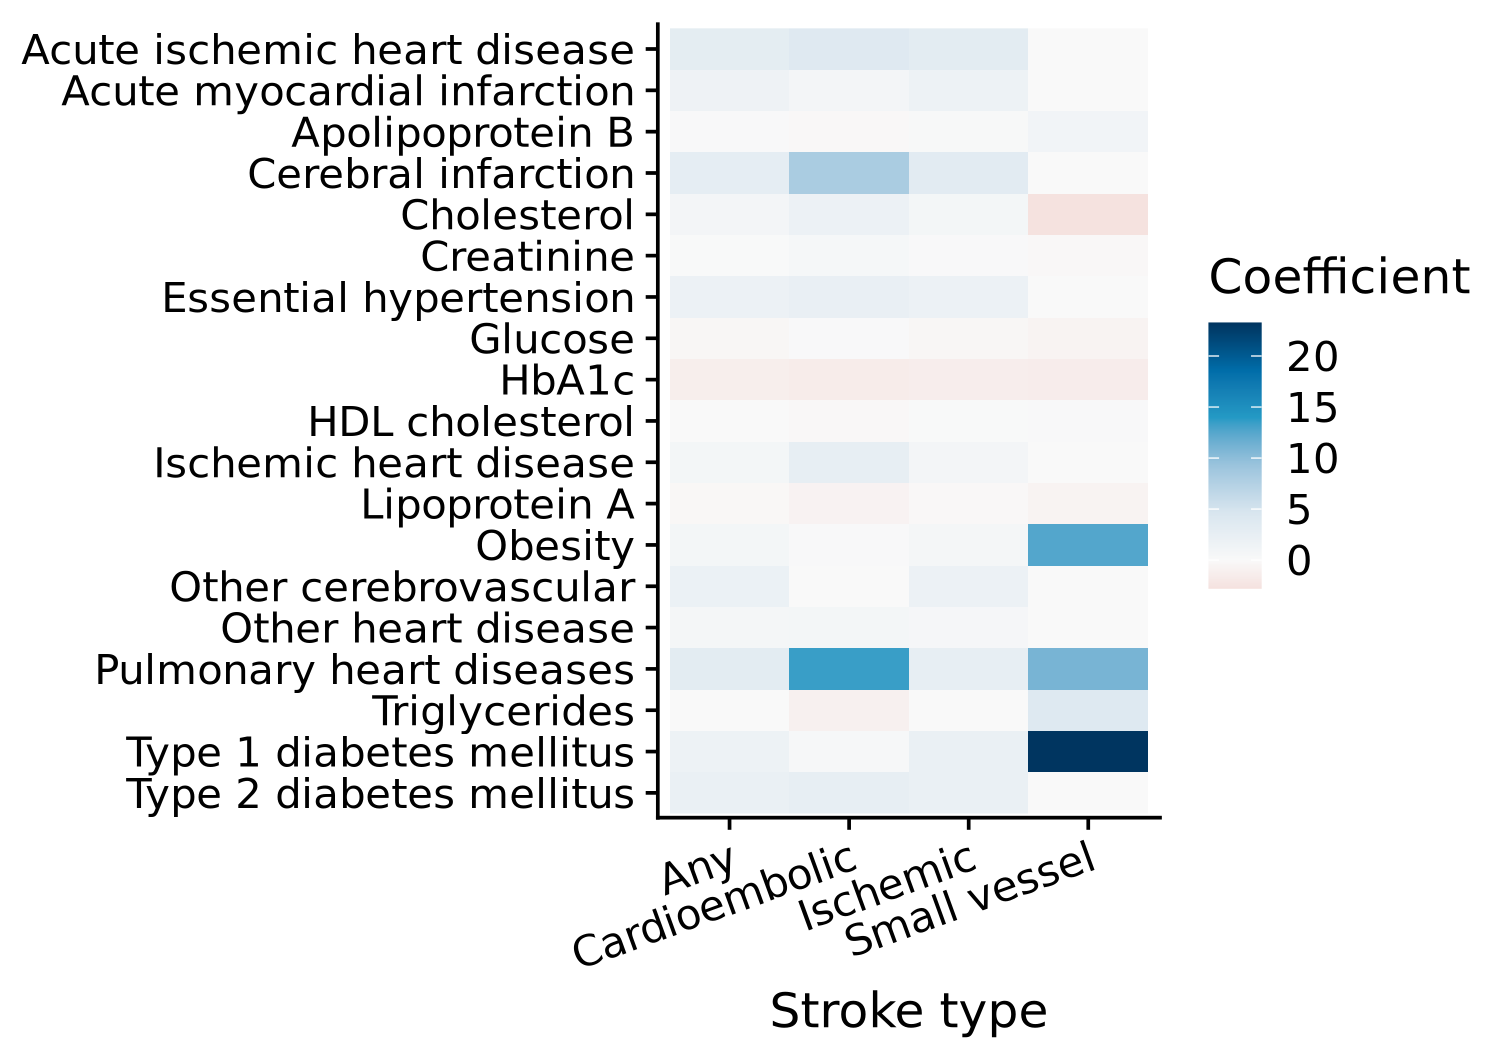

In [6]:
options(repr.plot.width = 6, repr.plot.height = 4.25, repr.plot.res = 250)

plot_df %>%
    ggplot(aes(y = term, x = phenotype, fill = estimate)) +
    geom_raster() +
    theme_cowplot() +
    theme(
        axis.text.x = element_text(angle = 20, hjust = 1),
        axis.title.y = element_blank(),
    ) +
    xlab("Stroke type") +
    scale_fill_continuous_divergingx(name = "Coefficient", palette = "RdBu", mid = 0) +
    scale_y_discrete(limits = rev)

# Forward approach

In [7]:
pcov_df <- read_tsv("data/pcov/naive_full.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
    rename(phenotype1 = `...1`) %>%
    pivot_longer(-phenotype1, names_to = "phenotype2", values_to = "pcov")

pcov_df  %>% head(2)

phenotype1,phenotype2,pcov
<chr>,<chr>,<dbl>
b_E10,b_E10,0.009821947
b_E10,b_E11,0.006666513


In [8]:
gcov_df <- read_tsv("data/gcov/MEGASTROKE.naive.tsv", show_col_types = F) %>%
    filter(!str_detect(phenotype_id, "sub"))

gcov_df %>% head(2)

Component,Value,SD,megastroke_phenotype,phenotype_id
<chr>,<dbl>,<dbl>,<chr>,<chr>
Her1_All,0.013192,0.001498,1.AS,b_E10
Her2_All,0.024693,0.018164,1.AS,b_E10


In [9]:
filtered_gcov_df <- gcov_df %>%
    filter(Component == "Her2_All", Value >= 0, Value <= 1) %>%
    distinct(phenotype_id) %>%
    inner_join(gcov_df, by = "phenotype_id") %>%
    filter(Component == "Cor_All", Value >= -1, Value <= 1) %>%
    distinct(phenotype_id, megastroke_phenotype) %>%
    inner_join(gcov_df, by = c("phenotype_id", "megastroke_phenotype")) %>%
    filter(Component == "Coher_All") %>%
    select(-Component)

In [10]:
compute_maxgcp <- function(dataframe) {
    features <- dataframe$phenotype_id
    
    this_df <- dataframe %>%
        inner_join(pcov_df, by = c("phenotype_id" = "phenotype1")) %>%
        pivot_wider(names_from = phenotype2, values_from = pcov)

    X <- this_df %>% 
        as.data.frame %>%
        column_to_rownames("phenotype_id") %>%
        as.matrix %>%
        {
            .[features, c("gcov", features)]
        }

    y <- X[, "gcov"]
    X <- X[, features]
    
    beta <- solve(X, y)
    beta <- beta / sqrt(beta %*% X %*% beta)
    beta <- beta %>% set_names(names(y))
    beta
}

In [11]:
# Quick check, these should be similar, at least for the quantitative traits that 
# were already scaled.
beta <- filtered_gcov_df %>%
    filter(megastroke_phenotype == "1.AS") %>%
    select(phenotype_id, gcov = Value) %>%
    compute_maxgcp()

lm_df %>%
    filter(maxgcp_type == "maxgcp_full_1.AS") %>%
    select(term, estimate) %>%
    mutate(
        maxgcp_manual = term %>% recode(!!!beta),
        # Estimate isn't scaled to unit phenotypic variance. Scale it
        # so that these are comparable.
        estimate = estimate / (last(estimate) / last(maxgcp_manual))
    ) %>%
    filter(term %>% str_starts("q_"))

term,estimate,maxgcp_manual
<chr>,<dbl>,<dbl>
q_30640_0,0.024174867,0.024002953
q_30690_0,0.109321263,0.108645990
q_30700_0,0.009702152,0.009711031
q_30740_0,-0.044308838,-0.044240028
q_30750_0,-0.158336370,-0.159332380
q_30760_0,0.003465428,0.003450395
q_30790_0,-0.031543836,-0.031351664
q_30870_0,-0.002894167,-0.002894167


In [12]:
maxgcp_coef_df <- filtered_gcov_df %>%
    select(megastroke_phenotype, phenotype_id, gcov = Value) %>%
    nest(data = -megastroke_phenotype) %>%
    rowwise() %>%
    mutate(beta = data %>% compute_maxgcp %>% list) %>%
    ungroup %>%
    select(-data) %>%
    unnest_wider(beta) %>%
    pivot_longer(-megastroke_phenotype, names_to = "feature") %>%
    drop_na %>%
    mutate(
        phenotype = megastroke_phenotype %>% 
            str_remove("^[0-5]\\.") %>%
            recode(!!!megastroke_phenotypes),
        feature = feature %>% recode(!!!reversed_feature_phenotypes)
    ) %>%
    select(phenotype, feature, value)

maxgcp_coef_df %>% write_parquet("plot_data/maxgcp_coef.parquet")

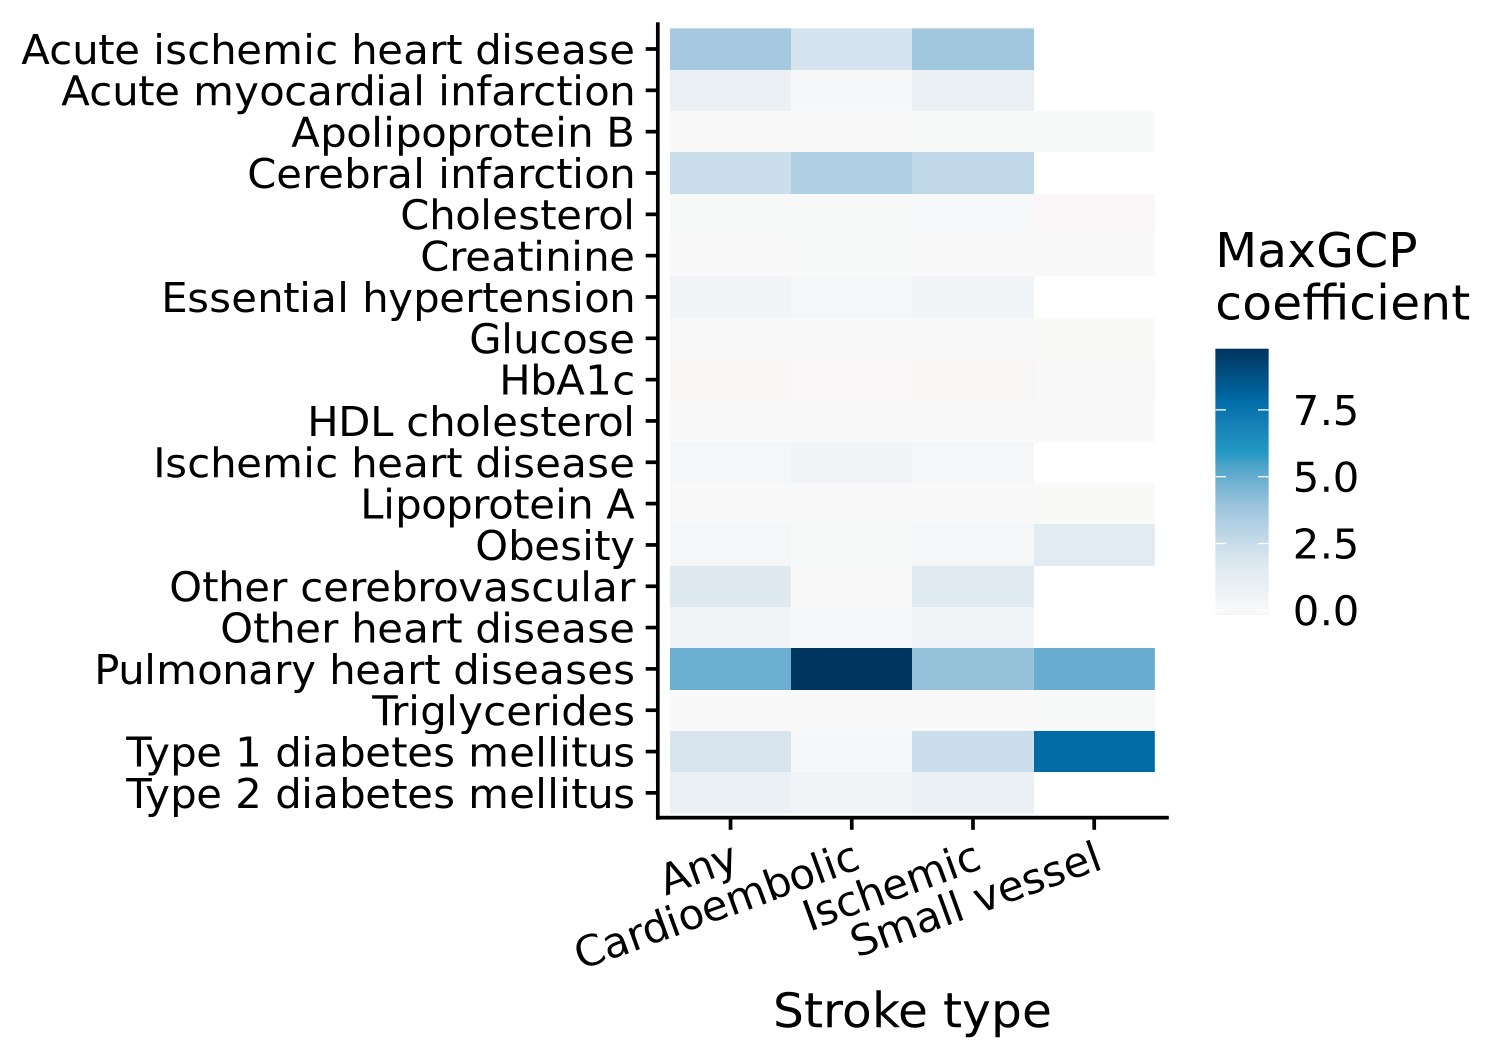

In [13]:
options(repr.plot.width = 6, repr.plot.height = 4.25, repr.plot.res = 250)

coef_plot <- maxgcp_coef_df %>%
    ggplot(aes(y = feature, x = phenotype, fill = value)) +
    geom_raster() +
    theme_cowplot() +
    theme(
        axis.text.x = element_text(angle = 20, hjust = 1),
        axis.title.y = element_blank(),
    ) +
    xlab("Stroke type") +
    scale_fill_continuous_divergingx(name = "MaxGCP\ncoefficient", palette = "RdBu", mid = 0) +
    scale_y_discrete(limits = rev)

save_plot("img/maxgcp_coef.png", coef_plot, base_width = 6, base_height = 4.25, 
          dpi = 400, bg = "white")

coef_plot

# Plot top features vs phenotypes

In [14]:
plot_df <- merged_df %>%
    select(IID, b_I27, b_I63, b_I24, b_E10, starts_with("maxgcp_")) %>%
    mutate(
        across(starts_with("b_"), ~recode_factor(. - 2, `1` = "Case", `0` = "Control")),
        across(starts_with("maxgcp_"), ~scale(.) %>% as.double)
    ) %>%
    pivot_longer(starts_with("b_"), names_to = "naive_phenotype", values_to = "naive_value") %>%
    rename_with(~str_remove(., "maxgcp_full_[0-5]\\.")) %>%
    pivot_longer(c(-IID, -naive_phenotype, -naive_value), names_to = "maxgcp_phenotype", 
                 values_to = "maxgcp_value") %>%
    mutate(
        naive_phenotype = naive_phenotype %>% recode(!!!reversed_feature_phenotypes),
        maxgcp_phenotype = maxgcp_phenotype %>% recode(!!!megastroke_phenotypes),
    )

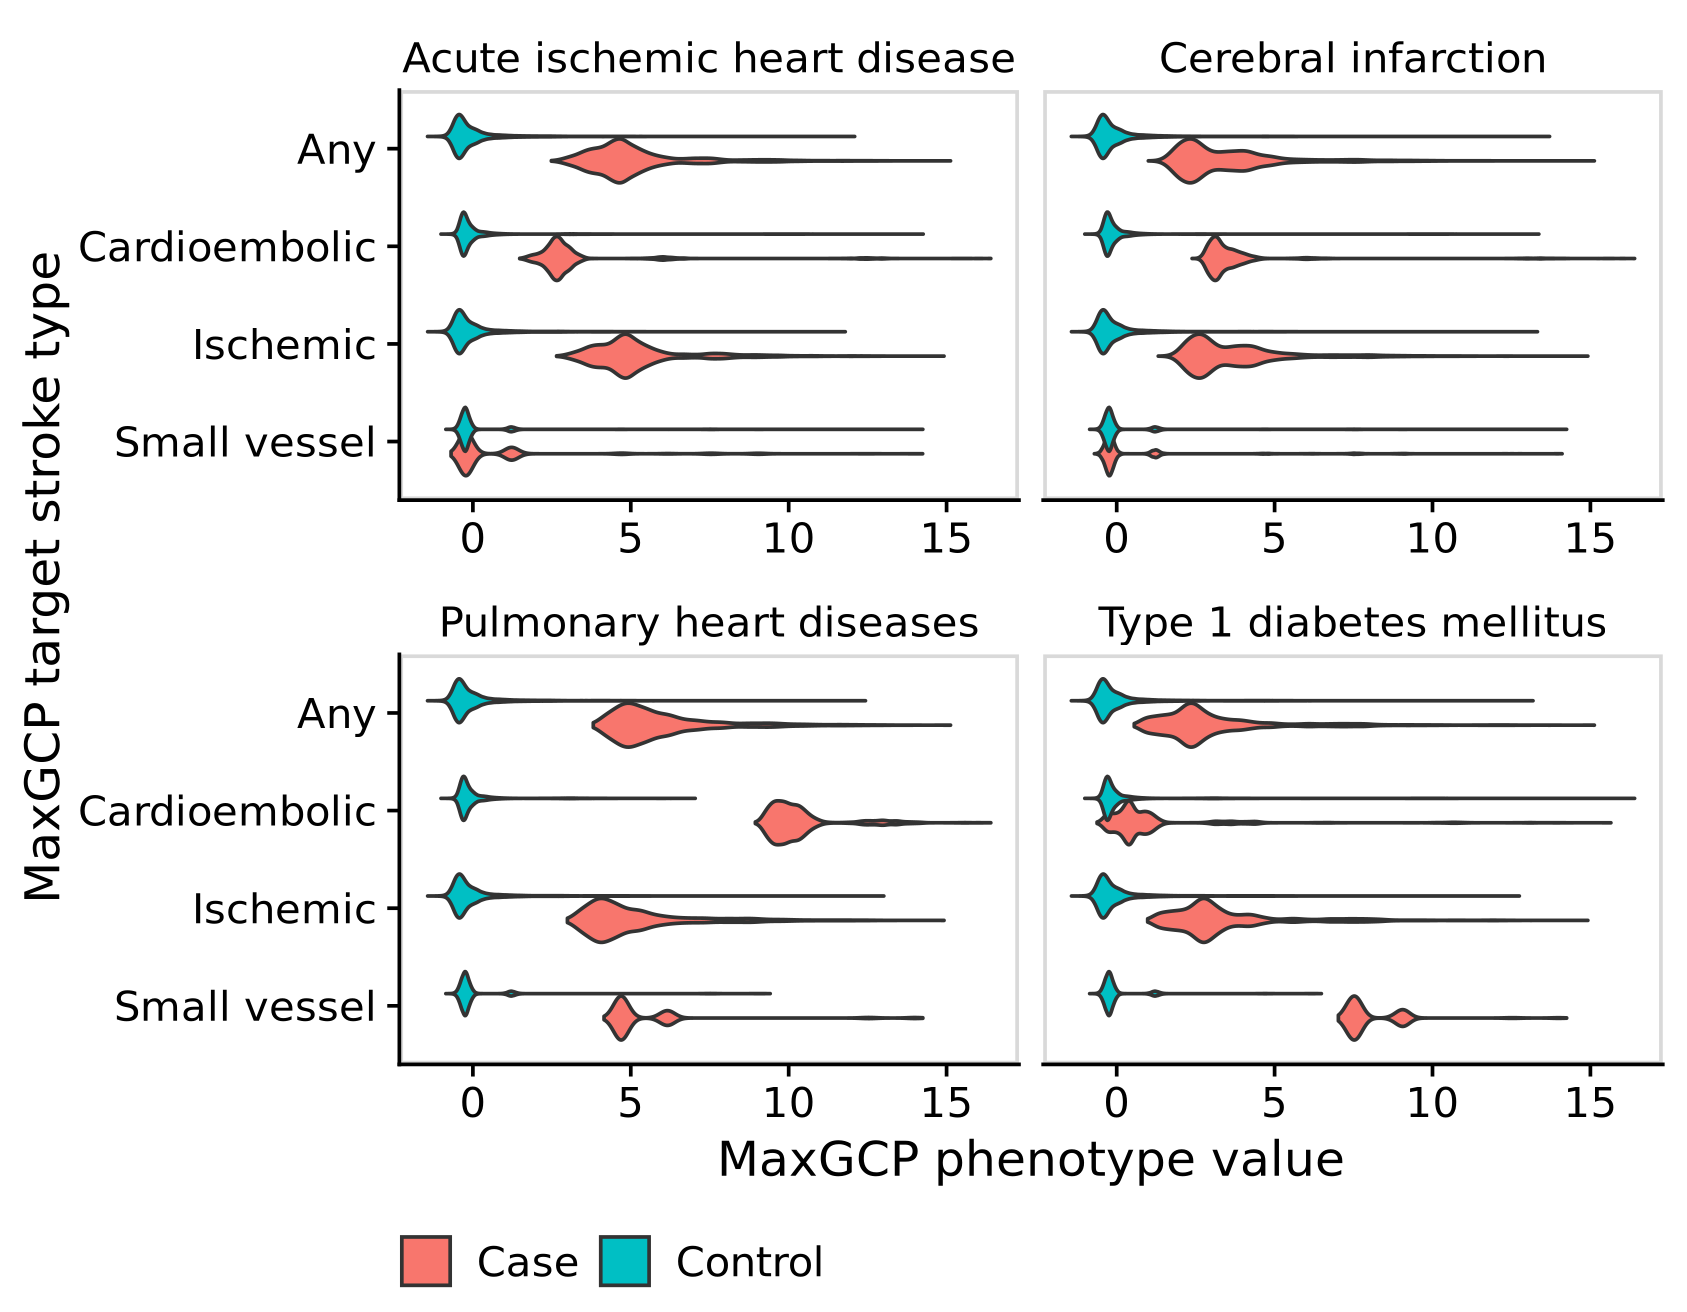

In [15]:
options(repr.plot.width = 6.75, repr.plot.height = 5.25, repr.plot.res = 250)

top_features_plot <- plot_df %>%
    ggplot(aes(y = maxgcp_phenotype, x = maxgcp_value, fill = naive_value)) +
    geom_violin(scale = "width", position = position_dodge(width = 0.5)) +
    facet_wrap(vars(naive_phenotype), scales = "free_x") +
    ylab("MaxGCP target stroke type") +
    xlab("MaxGCP phenotype value") +
    theme_cowplot() +
    theme(
        strip.background = element_blank(),
        legend.position = "bottom"
    ) +
    panel_border() +
    guides(fill = guide_legend(title = NULL)) +
    scale_y_discrete(limits = rev)

save_plot("img/top_features.png", top_features_plot, base_width = 6.75, base_height = 5.25, 
          dpi = 400, bg = "white")

top_features_plot